# Hypothesis testing for humans: Do the Umps Really Want to Go Home?

In this post we'll discuss and apply two techniques for hypothesis testing beyond the typical approach presented in most introductory statistics courses within the context of Major League Baseball.

If any of these buzzwords interest you, keep reading.

- Monte Carlo
- Bayesian Inference
- pymc3
- A/B tests
- Major League Baseball
- Statcast data

# Hypothesis testing for humans

Hypothesis testing methods such as the [z-test](https://en.wikipedia.org/wiki/Z-test) and [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) are ubiquitous in introductory statistics courses. I would wager that nearly all STEM majors have seen this approach at one time or another and that many students of other disciplines such as psychology, sociology, etc. have also been exposed to this kind of hypothesis testing.

However these classic methods are not the only tools at our disposal. In this post we'll deomonstrate how to use [resampling](https://en.wikipedia.org/wiki/Resampling_(statistics) and [bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference#Probability_of_a_hypothesis) for hypothesis testing. For a discussion of why you might prefer to use one of the methods discussed in this post over the traditional methods see the summary below.

# Do the umps really want to go home?

Now that we've established the methods we want to demonstrate let's consider the problem at hand.

Ealier this year in April FiveThirtyEight put out an article titled [Everyone Wants To Go Home During Extra Innings — Maybe Even The Umps](https://fivethirtyeight.com/features/everyone-wants-to-go-home-during-extra-innings-maybe-even-the-umps/). The article suggests that umpires are more likely to mis-call balls/strikes in situations could help end a game that has gone into extra innings. In particular the article questions the following scenarios occuring in the bottom of an extra inning

1. The away team holds the lead and a pitch that was actually a ball is called a strike (thus limiting the opportunity for the home team to tie the away team's score and prolong the game).
2. A pitch that was actually a strike is called a ball when the home team has runners on base (thus extending the opportunity for the home team to score a [walk-off](https://en.wikipedia.org/wiki/Walk-off_home_run) hit).

The article has some nice graphics which show the percent increase of incorrect calls could have helped to "accelerate" a game in extra innings from 2008-2016.

In this post we'll run with the gist of this article and perform hypothesis tests that address whether umpires incorrectly call more pitches strikes when it helps accelerate the away team leaving with a victory in the 2018 season.

# The data

Before going any further let's take a quick look at the data.

I used [pybaseball](https://github.com/jldbc/pybaseball) to acquire the data for this post. You can find the entire data pull [here](https://github.com/dantegates/mlb-statcast/blob/master/hypothesis-testing-for-humans-data-pull.ipynb). The data set consists of the total number of incorrect called strikes for the bottom of each extra inning in the 2018 season and whether the away team was holding onto the lead.

Let's read in the data and plot the observations.

In [1]:
import pandas as pd
data = pd.read_csv('hypothesis_testing_for_humans.csv')
data.head()

,game_pk,inning,away_team_advantage,strike_call_incorrect
0,529412.0,10.0,0,0
1,529412.0,11.0,0,1
2,529413.0,10.0,0,0
3,529413.0,11.0,0,0
4,529413.0,12.0,1,0


In [2]:
data.shape

(428, 4)

len(observations1) = 317 len(observations2) = 111
mean(observations1) = 0.27129337539432175 mean(observations2) = 0.2882882882882883


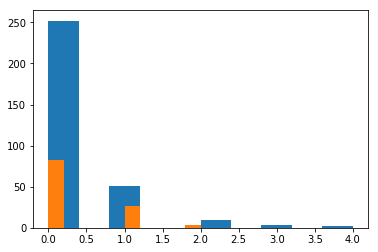

In [3]:
import matplotlib.pyplot as plt
observations_all = data.strike_call_incorrect
observations1 = data[data.away_team_advantage == 0].strike_call_incorrect
observations2 = data[data.away_team_advantage == 1].strike_call_incorrect
print('len(observations1) =', len(observations1), 'len(observations2) =', len(observations2))
print('mean(observations1) =', observations1.mean(), 'mean(observations2) =', observations2.mean())
_ = plt.hist(observations1)
_ = plt.hist(observations2)

The distributions look roughly the same, but looks can be deceiving. The mean balls called strikes is larger when the away team leads, so maybe the FiveThirtyEight article is on to something. Let's move on to the hypothesis tests. At this point if you are more interested in one method over another go ahead and skip to that section.

# Resampling

You can find a decent outline of what resampling is [here](https://en.wikipedia.org/wiki/Resampling_(statistics). The approach is very simple, and as I said above, very intuitive, so we won't go into to much detail here.

The basic idea here is to

1. Record the difference of the observed means of both distributions, $x_{1}, x_{2}$.
2. Perform a monte carlo experiment as follows. For a given number of iterations "shuffle" *all* observations together and split the shuffled list into two distributions each one with a size corresponding to the observed distributions. At each iteration record the difference of the means of these distributions.
3. After the simulation is complete the observed mean difference is compared to the distribution of simulated mean differences. An observed mean difference is less than the least 2.5% of the simulated values or greater than the largest 2.5% of the simulated values indicates that umpires are incorrectly calling strikes more often in situations that would hasten the end of the game.

Let's take note of the observed mean difference.

In [4]:
observed_mean_diff = observations1.mean() - observations2.mean()
observed_mean_diff

-0.01699491289396654

Now we'll perform the monte carlo experiment.

In [5]:
import numpy as np

n = len(observations_all)
n1, n2 = len(observations1), len(observations2)
deltas = []
for _ in range(50_000):
    indices = np.random.choice(n, size=n, replace=False)
    idx1, idx2 = indices[:n1], indices[n1:]
    x1 = observations_all[idx1]
    x2 = observations_all[idx2]
    deltas.append(x1.mean() - x2.mean())
deltas = np.array(deltas)

A plot shows the simulated values are roughly normal and centered close to 0. It also shows that our observed mean difference is well within the 95% range, which fails to indicate that umpires are calling strikes differently to end the game more quickly.

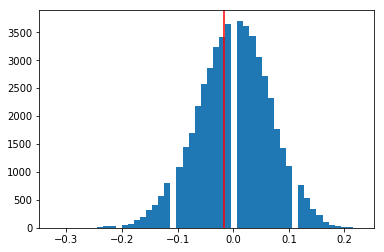

In [6]:
import matplotlib.pyplot as plt
_ = plt.hist(deltas, bins=50)
_ = plt.gca().axvline(observed_mean_diff, color='r')

Lastly we can verify this numerically.

In [7]:
deltas.sort()
idx1 = np.argwhere(deltas <= observed_mean_diff).max()
idx2 = np.argwhere(deltas >= observed_mean_diff).min()
assert idx1 / len(deltas) > 0.025
assert idx2 / len(deltas) < 0.975

# Bayesian Inference

We will now use Bayesian Inference to test whether umpires are more likely to incorrectly call a strike when the away team leads in the bottom of an extra inning. This approach can be outlined roughly as follows

- First the problem is described as a probabalistic model. In our case the distribution of incorrect strike calls when the away team leads and when the game is tied will each be modelled as individual Poisson distributions. Each distribution has its own prior on the value of the parameter `mu` but each prior distribution has the same parameters.
- Next, we use `pymc3` to obtain a posterior distributions of the model parameters.
- Lastly, using estimates of the model parameters obtained from the posterior we simulate the differences of the two distributions, similar to above.

In [9]:
import pymc3 as pm

with pm.Model() as model:
    mu = pm.Uniform('mu', 0, 5, shape=2)
    tie_game = pm.Poisson('tie_game', mu[0], observed=observations1)
    away_team_leads = pm.Poisson('away_team_leads', mu[1], observed=observations2)
    delta = pm.Deterministic('delta', mu[0] - mu[1])
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2589.74draws/s]
The acceptance probability does not match the target. It is 0.8816513307323324, but should be close to 0.8. Try to increase the number of tuning steps.


The trace shows that the sampling process converged.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11740c208>,
      dtype=object)

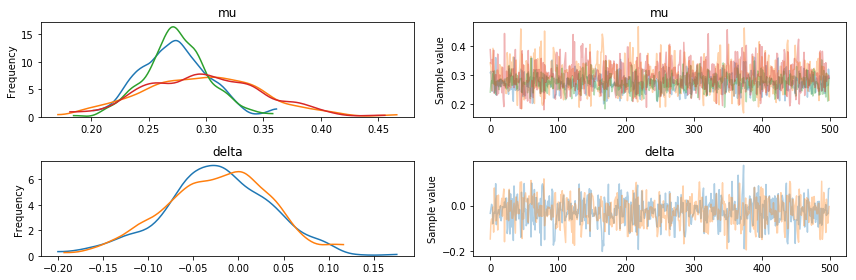

In [10]:
pm.plots.traceplot(trace[-500:])

We can now observe the mean balls called strikes per inning by sampling from the posterior. We find that both distributions seem to be centered around the same value and the distribution for when the away team has a higher variance as we have less data for that case and thus there is more uncertainty in our parameter estimates.

To answer the question of whether umpires are trying to end the game early we can examine the difference of the model parameters from the posterior. In this case to conclude that umpires are calling balls and strikes differently in cases that might end the game early versus the rest of the game we would need to find a difference of 0 to have occurred in less than 2.5% of the posterior samples. `pymc3` has a convenient function for this called `plot_posterior()` which, in this case, show that 0 is well within the 95% credible region, indicating that the umpires are calling balls and strikes consistently thoughout the game.

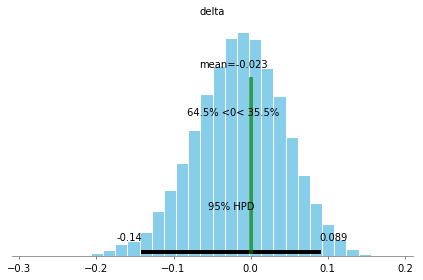

In [14]:
pm.plot_posterior(trace, varnames=['delta'], ref_val=0)

# Summary

It seems umpires are off the hook, at least from our (purposely) simple tests.

However, you may be wondering why or when to use resampling or bayesian inference of $z$ or $t$ tests.

It should be noted that each hypothesis testing methods available has its own long line of criticisms that the practitioner should be aware of. This is a large topic that is well documented so I won't go in to many details here. Instead I'll simply give two critera I personally consider in choosing a method to use for hypothesis testing.

*Resampling*, in my opinion, shines because it feels much more intuitive than traditional methods like the $z$ test. As Jake Vanderplas [has said](https://www.youtube.com/watch?v=Iq9DzN6mvYA) "if you can write a for loop you can do statistics". With resampling there is no need to remember the difference between $z,t$ or $\chi^{2}$ or to search through tables. The data you have at hand is all you need and if you want to quickly test a hypothesis you can simply sample and simulate. As seen above the code feels very natural and I was able to write the simulation without having to consult references. This is a big benefit for productivity and the ability to explain your results to a variety of audiences.

The advantage of using Bayesian Inference is that the posterior probability usually addresses the question we are asking with an answer closest to what we are looking for. For more details on this point [this paper](http://www.stat.columbia.edu/~gelman/research/published/pvalues3.pdf) by Andrew Gelman and [this series of blog posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake Vanderplas are excellent resources.